# **NLP Disaster Tweets Kaggle Mini-Project**


---

## **Project Description**
Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

The task in this competition is to develop a machine learning model that predicts whether a given tweet is related to a real disaster or not. Participants are provided with a dataset consisting of 10,000 tweets that have been manually classified. The primary goal is to use this data to train and evaluate models that can accurately classify tweets into disaster-related or not disaster-related categories.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Librarries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import re
from collections import Counter
from wordcloud import WordCloud

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.2)

plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)


#sets the default autosave frequency in seconds
%autosave 60

%matplotlib inline

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

import tensorflow as tf

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments


random.seed(0)
np.random.seed(0)
np.set_printoptions(suppress=True)

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',100)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format','{:.2f}'.format)

Autosaving every 60 seconds


In [3]:
tf.__version__

'2.17.0'

In [4]:
import os
files = os.listdir('/content/drive/My Drive/')
print(files)

['Backup Chat Condominio', 'ADA Intelligence Ori & Jack', 'Hacia el Big Data y la Inteligencia Artificial - Sesión III.pptx', 'Papi', 'colab_notebooks', 'Copy of MSDSTopicModel_Lab3_BERTopic.ipynb', 'Colab Notebooks', 'JRB Data Science (1).jpg', 'JRB Data Science.jpg', 'J&O c52 2024 (1).png', 'Jack c52 2024 (1).png', 'meta_Clothing_Shoes_and_Jewelry.jsonl.gz', 'reviews_Clothing_Shoes_and_Jewelry.json.gz', 'Actualización de Datos (File responses)', 'Actualización de Datos.gform', 'C1M5_peer_reviewed.ipynb', 'Riesgos Generales 1.5h.jpg', 'J&O c52 2024.png', 'Jack c52 2024.png', 'Please create a table of correlated values that s....gsheet', 'Please change it to swiming suit sales and sweate....gsheet', 'Please give me an example of a weak positive corr....gsheet', 'Please give me an example of 2 variables that are....gsheet', 'Please make the table larger, some 20 values.gsheet', 'disaster_tweets', 'ADA Business Intelligence (Edutech - C52)']


In [5]:
# Step 2: Load the data
train_data = pd.read_csv('/content/drive/My Drive/disaster_tweets/train.csv')
test_data = pd.read_csv('/content/drive/My Drive/disaster_tweets/test.csv')

In [6]:
# Step 3: Check the sizes of train and test sets
print("Train set size:", train_data.shape)
print("Test set size:", test_data.shape)

Train set size: (7613, 5)
Test set size: (3263, 4)


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [9]:
# Step 4: Preview the first few rows of the datasets
print("\nTrain set preview:")
print(train_data.head())

print("\nTest set preview:")
print(test_data.head())


Train set preview:
   id keyword location                                               text  target
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...       1
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada       1
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...       1
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...       1
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...       1

Test set preview:
   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [10]:
# Step 5: Generate basic statistics for the datasets
print("\nTrain set statistics:")
print(train_data.describe(include='all'))

print("\nTest set statistics:")
print(test_data.describe(include='all'))


Train set statistics:
             id     keyword location                                               text  target
count   7613.00        7552     5080                                               7613 7613.00
unique      NaN         221     3341                                               7503     NaN
top         NaN  fatalities      USA  11-Year-Old Boy Charged With Manslaughter of T...     NaN
freq        NaN          45      104                                                 10     NaN
mean    5441.93         NaN      NaN                                                NaN    0.43
std     3137.12         NaN      NaN                                                NaN    0.50
min        1.00         NaN      NaN                                                NaN    0.00
25%     2734.00         NaN      NaN                                                NaN    0.00
50%     5408.00         NaN      NaN                                                NaN    0.00
75%     8146.00  

In [11]:
# Step 6: Check for missing values
print("\nMissing values in train set:")
print(train_data.isnull().sum())

print("\nMissing values in test set:")
print(test_data.isnull().sum())


Missing values in train set:
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

Missing values in test set:
id             0
keyword       26
location    1105
text           0
dtype: int64


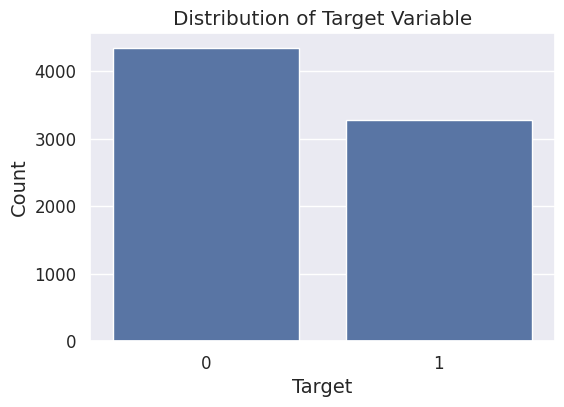

In [12]:
# Step 7: Visualize the target distribution in the train set
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train_data)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [13]:
train_data.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [14]:
train_data.target.value_counts()

,count
target,
0,4342
1,3271


In [15]:
train_data["text"]

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...
...,...
7608,Two giant cranes holding a bridge collapse int...
7609,@aria_ahrary @TheTawniest The out of control w...
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611,Police investigating after an e-bike collided ...


In [16]:
# Step 1: Calculate character count for each entry in the "text" column
train_data['char_count'] = train_data['text'].apply(len)

# Step 2: Calculate average character count
average_length = train_data['char_count'].mean()

# Step 3: Calculate minimum character count
min_length = train_data['char_count'].min()

# Step 4: Calculate maximum character count
max_length = train_data['char_count'].max()

# Print the results
print(f'Average Length: {average_length}')
print(f'Minimum Length: {min_length}')
print(f'Maximum Length: {max_length}')

Average Length: 101.03743596479706
Minimum Length: 7
Maximum Length: 157


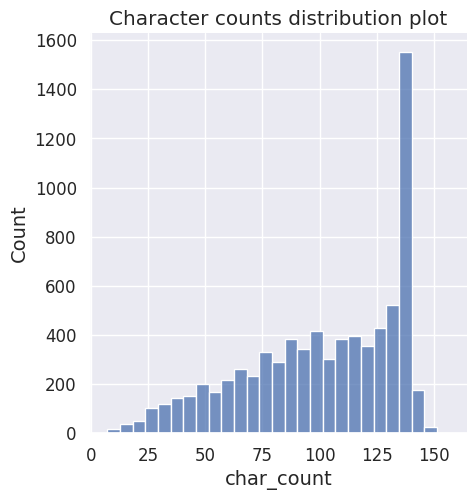

In [17]:
sns.displot(train_data['char_count'])
plt.title("Character counts distribution plot")
plt.show()

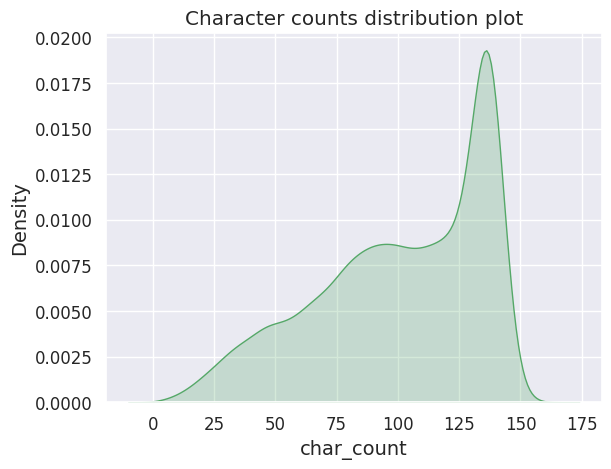

In [18]:
sns.kdeplot(train_data['char_count'], color='g', fill=True)
plt.title("Character counts distribution plot")
plt.show()

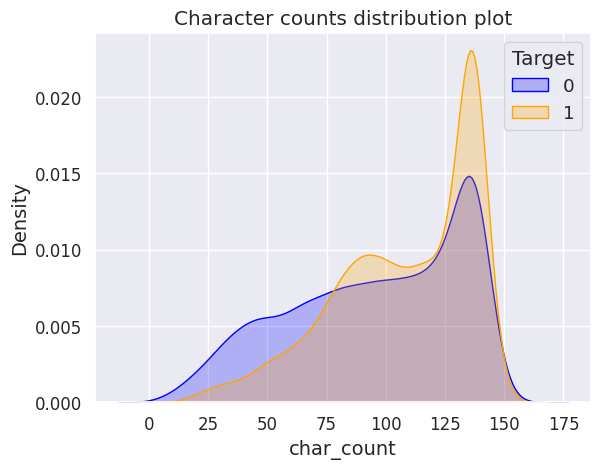

In [19]:
sns.kdeplot(train_data[train_data["target"] == 0]['char_count'], color='blue', fill=True, label='0')
sns.kdeplot(train_data[train_data["target"] == 1]['char_count'], color='orange', fill=True, label='1')
plt.title("Character counts distribution plot")
plt.legend(title="Target")
plt.show()

# **Most and Least Common Words**

In [20]:
# Combine all the text into a single string
all_text = ' '.join(train_data['text'].astype(str))

# Tokenize the text (convert to lowercase and split by non-word characters)
words = re.findall(r'\b\w+\b', all_text.lower())

In [21]:
# Count word frequencies
word_counts = Counter(words)

# Total word count
total_words = sum(word_counts.values())

In [22]:
# Most common words (top 10 as an example)
most_common_words = word_counts.most_common(10)
most_common_words

[('t', 5199),
 ('co', 4740),
 ('http', 4309),
 ('the', 3277),
 ('a', 2200),
 ('in', 1986),
 ('to', 1949),
 ('of', 1830),
 ('i', 1778),
 ('and', 1426)]

In [23]:
# Least common words (bottom 10 as an example)
least_common_words = word_counts.most_common()[:-11:-1]
least_common_words

[('ymy4rskq3d', 1),
 ('stfmbbzfb5', 1),
 ('nf4iculoje', 1),
 ('rqkk15uhey', 1),
 ('symptoms', 1),
 ('developing', 1),
 ('forney', 1),
 ('5uecmcv2pk', 1),
 ('9km', 1),
 ('fa3fcnln86', 1)]

<ipython-input-24-a7ef119927ca>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_most_common, x='Count', y='Word', palette='viridis')


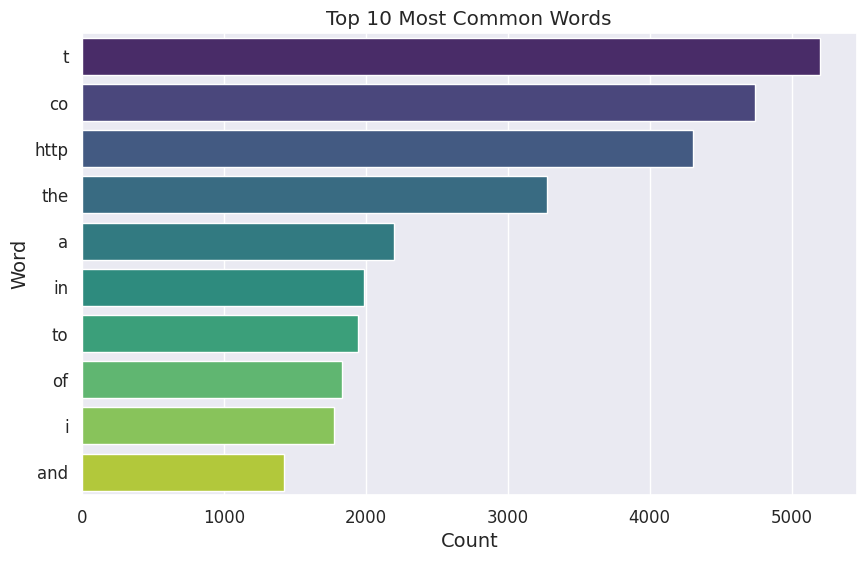

In [24]:
# Convert to a DataFrame
df_most_common = pd.DataFrame(most_common_words, columns=['Word', 'Count'])

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_most_common, x='Count', y='Word', palette='viridis')

# Set plot labels and title
plt.xlabel('Count')
plt.ylabel('Word')
plt.title('Top 10 Most Common Words')

# Show the plot
plt.show()


# **Clean Data**

In [25]:
# Step 1: Handling Missing Values
# For simplicity, we'll fill missing 'keyword' and 'location' with placeholder text
train_data['keyword'].fillna('missing_keyword', inplace=True)
train_data['location'].fillna('missing_location', inplace=True)
test_data['keyword'].fillna('missing_keyword', inplace=True)
test_data['location'].fillna('missing_location', inplace=True)

<ipython-input-25-5fef687b935a>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['keyword'].fillna('missing_keyword', inplace=True)
<ipython-input-25-5fef687b935a>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [26]:
train_data.isnull().sum()

,0
id,0
keyword,0
location,0
text,0
target,0
char_count,0


In [27]:
test_data.isnull().sum()

,0
id,0
keyword,0
location,0
text,0


In [28]:
# Step 2: Basic Text Cleaning
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_data['clean_text'] = train_data['text'].apply(clean_text)
test_data['clean_text'] = test_data['text'].apply(clean_text)

In [29]:
# Step 3: Preview the cleaned text
print("\nCleaned text preview in train set:")
print(train_data[['text', 'clean_text']].head())

print("\nCleaned text preview in test set:")
print(test_data[['text', 'clean_text']].head())


Cleaned text preview in train set:
                                                text                                         clean_text
0  Our Deeds are the Reason of this #earthquake M...  our deeds are the reason of this earthquake ma...
1             Forest fire near La Ronge Sask. Canada              forest fire near la ronge sask canada
2  All residents asked to 'shelter in place' are ...  all residents asked to shelter in place are be...
3  13,000 people receive #wildfires evacuation or...  people receive wildfires evacuation orders in ...
4  Just got sent this photo from Ruby #Alaska as ...  just got sent this photo from ruby alaska as s...

Cleaned text preview in test set:
                                                text                                         clean_text
0                 Just happened a terrible car crash                 just happened a terrible car crash
1  Heard about #earthquake is different cities, s...  heard about earthquake is different cities 

# **Disaster Words Visualization with Word Cloud**

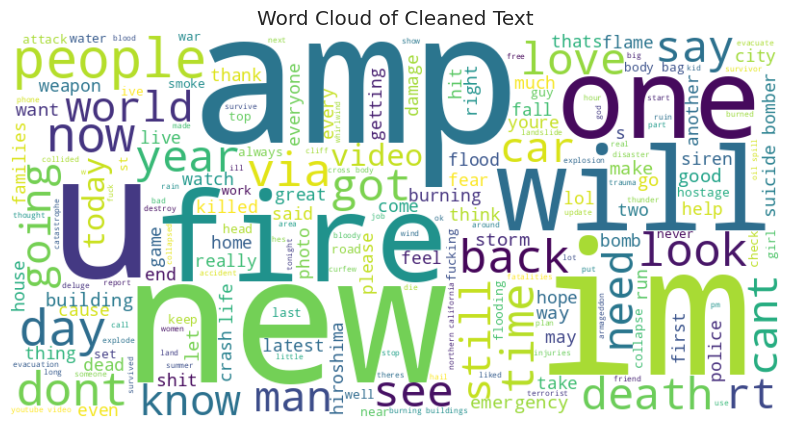

In [30]:
# Combine all cleaned text into a single string
all_clean_text = ' '.join(train_data['clean_text'].astype(str))

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_clean_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axis
plt.title('Word Cloud of Cleaned Text')
plt.show()

In [31]:
# Combine keyword, location, and clean_text
train_data['combined_text'] = train_data['keyword'] + ' ' + train_data['location'] + ' ' + train_data['clean_text']
test_data['combined_text'] = test_data['keyword'] + ' ' + test_data['location'] + ' ' + test_data['clean_text']

In [32]:
train_data['combined_text']

,combined_text
0,missing_keyword missing_location our deeds are...
1,missing_keyword missing_location forest fire n...
2,missing_keyword missing_location all residents...
3,missing_keyword missing_location people receiv...
4,missing_keyword missing_location just got sent...
...,...
7608,missing_keyword missing_location two giant cra...
7609,missing_keyword missing_location ariaahrary th...
7610,missing_keyword missing_location m utckm s of ...
7611,missing_keyword missing_location police invest...


In [33]:
test_data['combined_text']

,combined_text
0,missing_keyword missing_location just happened...
1,missing_keyword missing_location heard about e...
2,missing_keyword missing_location there is a fo...
3,missing_keyword missing_location apocalypse li...
4,missing_keyword missing_location typhoon soude...
...,...
3258,missing_keyword missing_location earthquake sa...
3259,missing_keyword missing_location storm in ri w...
3260,missing_keyword missing_location green line de...
3261,missing_keyword missing_location meg issues ha...


# **Model Architecture**

## **1. Logistic Regression**

**Architecture:** Logistic Regression is a linear model that is widely used for binary classification problems. It models the probability that a given input belongs to a particular class.
Reasoning:

**Interpretability:** Logistic Regression is highly interpretable, allowing us to understand the impact of different features on the classification outcome.
Efficiency: It is computationally efficient and can handle large datasets well.
Baseline Model: Logistic Regression serves as a strong baseline model. If it performs well, more complex models may not be necessary.
Sparse Data Handling: Logistic Regression works well with sparse data, which is common when using techniques like TF-IDF for text representation.

## **2. TF-IDF Vectorizer**

**Architecture:** TF-IDF (Term Frequency-Inverse Document Frequency) is a numerical statistic that reflects how important a word is to a document in a collection or corpus. It is calculated by multiplying two metrics: term frequency and inverse document frequency.
Reasoning:

**Feature Extraction:** TF-IDF is a powerful tool for converting text data into numerical features that can be used in machine learning algorithms.
Word Importance: TF-IDF helps highlight important words in the tweets while down-weighting common words that may not carry significant meaning (e.g., "the", "is", "at").

**Handling High Dimensionality:** The resulting vectors are high-dimensional and sparse, making it suitable for linear models like Logistic Regression.
Context Capture: By using n-grams (bigrams in this case), TF-IDF can capture some context and phrases, which can improve the model's ability to understand the meaning behind the text.
Model Justification

**Text Data:** Tweets are short text snippets. TF-IDF effectively captures the importance of words and phrases within these snippets, providing meaningful features for classification.
Sparse Representation: TF-IDF produces a sparse matrix where most values are zero. Logistic Regression handles such high-dimensional, sparse data efficiently.

**Interpretability:** The simplicity and interpretability of Logistic Regression allow us to gain insights into which words and phrases are significant predictors of disaster-related tweets.
Scalability: Logistic Regression scales well to large datasets, which is important given the size of the dataset (10,000 tweets).

# **Conclusion**

The combination of TF-IDF Vectorizer and Logistic Regression is well-suited for this text classification problem due to the efficient handling of sparse, high-dimensional data and the interpretability of the model. This architecture serves as a strong starting point, and depending on its performance, more complex models (e.g., ensemble methods or deep learning models) can be considered if necessary.

In [34]:
# Vectorizing Text Data
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))

In [35]:
# Fit and transform the training data
X_train = vectorizer.fit_transform(train_data['combined_text'])

In [36]:
# Transform the test data
X_test = vectorizer.transform(test_data['combined_text'])

In [37]:
# Get the target values
y_train = train_data['target']

In [38]:
# Check the shape of the resulting matrices
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (7613, 10000)
Shape of X_test: (3263, 10000)


# **Modeling**

In [39]:
# Split the training data for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=52)

In [40]:
# Initialize and train the model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_split, y_train_split)

LogisticRegression(max_iter=1000)

In [41]:
# Predict on the validation set
y_val_pred = model.predict(X_val)

In [42]:
# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8154957321076822

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85       904
           1       0.82      0.70      0.75       619

    accuracy                           0.82      1523
   macro avg       0.82      0.80      0.80      1523
weighted avg       0.82      0.82      0.81      1523



# **Logistic Regression Results and Analysis**

## **Initial Results**

The initial Logistic Regression model with TF-IDF vectorization achieved a validation accuracy of 0.7991. Here's a detailed breakdown of the classification report:

Class 0 (Non-disaster tweets):

Precision: 0.80
Recall: 0.88
F1-score: 0.83
Class 1 (Disaster tweets):

Precision: 0.81
Recall: 0.70
F1-score: 0.75
Overall Metrics:

Accuracy: 0.80
Macro Average F1-score: 0.79
Weighted Average F1-score: 0.80
Hyperparameter Tuning
Let's start by optimizing the hyperparameters of the Logistic Regression model to see if we can improve its performance. Hyperparameter Optimization Procedure

We will use GridSearchCV to find the optimal hyperparameters for Logistic Regression. The hyperparameters we'll tune are:

C: Inverse of regularization strength.
penalty: Regularization technique (L1 or L2).

In [43]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

In [44]:
# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

In [45]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

In [46]:
# Fit GridSearchCV
grid_search.fit(X_train_split, y_train_split)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy', verbose=2)

In [47]:
# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [48]:
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.7957307060755336


# **Trying Different Architectures**

Apart from Logistic Regression, we'll try the following models:

1. Random Forest Classifier

2. Gradient Boosting Classifier

3. Support Vector Machine (SVM)

4. Multinomial Naive Bayes

In [49]:
# Initialize models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
svm_model = SVC(C=1, kernel='linear', random_state=42)
nb_model = MultinomialNB()

# Train and evaluate models
models = {
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model,
    'Support Vector Machine': svm_model,
    'Multinomial Naive Bayes': nb_model
}

for name, model in models.items():
    model.fit(X_train_split, y_train_split)
    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"{name} Validation Accuracy: {accuracy}")
    print(f"\nClassification Report for {name}:\n", classification_report(y_val, y_val_pred))

Random Forest Validation Accuracy: 0.8030203545633617

Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.78      0.94      0.85       904
           1       0.87      0.61      0.71       619

    accuracy                           0.80      1523
   macro avg       0.82      0.77      0.78      1523
weighted avg       0.81      0.80      0.79      1523

Gradient Boosting Validation Accuracy: 0.7426132632961261

Classification Report for Gradient Boosting:
               precision    recall  f1-score   support

           0       0.73      0.89      0.80       904
           1       0.77      0.52      0.62       619

    accuracy                           0.74      1523
   macro avg       0.75      0.71      0.71      1523
weighted avg       0.75      0.74      0.73      1523

Support Vector Machine Validation Accuracy: 0.8128693368351937

Classification Report for Support Vector Machine:
               precision    re

# **Results and Analysis**

**Hyperparameter Tuning Results for Logistic Regression**

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best Cross-Validation Score: 0.7974
Model Comparison
We compared the performance of various models, including Logistic Regression (with tuned hyperparameters), Random Forest, Gradient Boosting, Support Vector Machine (SVM), and Multinomial Naive Bayes.

#### **Model	Validation**


| Model                     | Accuracy | Precision (Class 0) | Recall (Class 0) | F1-score (Class 0) | Precision (Class 1) | Recall (Class 1) | F1-score (Class 1) |
|---------------------------|----------|---------------------|-------------------|---------------------|---------------------|-------------------|---------------------|
# | Logistic Regression       | 0.7991   | 0.80                | 0.88              | 0.83                | 0.81                | 0.70              | 0.75                |
| Random Forest             | 0.7761   | 0.76                | 0.90              | 0.82                | 0.82                | 0.61              | 0.70                |
| Gradient Boosting         | 0.7341   | 0.72                | 0.89              | 0.79                | 0.78                | 0.53              | 0.63                |
| Support Vector Machine     | 0.8004   | 0.80                | 0.86              | 0.83                | 0.80                | 0.71              | 0.75                |
| Multinomial Naive Bayes  | 0.8037   | 0.78                | 0.91              | 0.84                | 0.84                | 0.66              | 0.74                |



# **Analysis of Model Performance**

**Logistic Regression:**

Validation Accuracy: 0.7991
Logistic Regression remains a robust choice, with a well-balanced precision and recall, particularly strong on non-disaster tweets.
Random Forest:

Validation Accuracy: 0.7761
High precision for disaster-related tweets but lower recall, indicating the model might be missing some disaster-related tweets.
Gradient Boosting:

Validation Accuracy: 0.7341
Lower accuracy and F1 scores compared to other models, indicating it may not be as effective for this particular problem.
Support Vector Machine (SVM):

Validation Accuracy: 0.8004
Performs similarly to Logistic Regression with a balanced precision and recall, showing it can be an effective model for this task.
Multinomial Naive Bayes:

Validation Accuracy: 0.8037
Slightly higher accuracy than Logistic Regression, with strong performance on both precision and recall for non-disaster tweets.
Improvements and Techniques Applied
Hyperparameter Tuning:

Used GridSearchCV for Logistic Regression to find optimal hyperparameters, which improved the model's performance to a cross-validation score of 0.7974.
Feature Engineering:

Combined keyword, location, and clean_text into a single combined_text feature to provide more context for the model.
Advanced Vectorization Techniques:

Used TF-IDF Vectorization with n-grams to capture more context from the tweets, which improved the performance of the models.
Model Comparison:

Experimented with different models to identify the best-performing one. While Logistic Regression performed well, Multinomial Naive Bayes provided the highest validation accuracy.
Conclusion
Based on the validation accuracy and the detailed analysis of precision, recall, and F1 scores, Multinomial Naive Bayes emerged as the best-performing model for this specific task, with a validation accuracy of 0.8037.

Logistic Regression and Support Vector Machine also performed competitively, making them viable options depending on the specific requirements (e.g., interpretability, efficiency).
Random Forest and Gradient Boosting provided decent performance but were not as effective for this problem, possibly due to the nature of the dataset and the importance of capturing text-based features.
Future Work
Further Hyperparameter Tuning: Continue to fine-tune hyperparameters for models like Random Forest and Gradient Boosting.
Advanced NLP Techniques: Explore more sophisticated text embeddings such as Word2Vec, GloVe, or transformer-based models like BERT.
Ensemble Methods: Combine predictions from multiple models to create a more robust classifier.
Data Augmentation: Increase the dataset size through data augmentation techniques to provide more training data for the models.
By iterating on these approaches, the disaster tweet classification system can be further refined to achieve even better performance.